# Table of Content 

1. Context
2. Data Loading
3. Data Cleaning
    1. Merge Trips & Start Station Information
    2. Merge Trips & Weather
    3. Remove Duplicates Value
    4. Drop Irrelevant columns
    5. Identify Missing Values
    6. Identify Missing Values
    7. Handle incorrect data and data types
    8. Handle outliers
4. Feature Enginnering
    1. Mean Euclidean Distance From Other stations 
    2. Zipcode Feature Extraction
    3. Age Binning
    4. Date and Time Feature Extraction and Encoding
5. Train Test Validation Split
6. Feature Scaling & Feature Encoding
7. Oversampling to Balance Class Imbalance
8. Model Building
    1. Random Forest
    2. Gradient Boost
    3. SVM
9. Conclusion
   








## 1. Context
Wheelie Wonka is a bike sharing company in Boston that aims to enhance the mobile app experience for its users. The company wants to show bike availability in the future to its users to help them plan their trips effectively. To achieve this, they need to predict the ending bike station at the beginning of a bike trip.



## 2. Data Loading

In [222]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV
from uszipcode import SearchEngine
from scipy.spatial.distance import cdist
import math
from scipy.stats import skew
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

# Set display options
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.float_format', str)

# Load the datasets
stations = pd.read_csv("hubway_stations.csv") # load the stations dataset
trips = pd.read_csv("hubway_trips.csv") # load the trips dataset
weather = pd.read_csv("weather.csv") # load the weather dataset

## 3 Data Cleaning

#### 3a Merge Start Station Information into Trips

In [2]:
# Make a copy of the 'stations' dataframe with column prefixes to avoid column name conflicts when merging
start_statn_info = stations.copy().add_prefix('strt_statn_')

# Merge the 'trips' dataframe with the new 'start_statn_info' dataframe using the 'strt_statn' and 'strt_statn_id' columns as keys
trips_station = pd.merge(trips, start_statn_info, how='left', left_on='strt_statn', right_on='strt_statn_id')

#### 3b Merge Weathers Information into Trips

- <font color='red'>The following columns will be excluded from the weather dataset since they contain only a single value: Station, Station_Name, Elevation, Latitude, Longitude, and Quality_Flag. The 'Measurement_Flag' column is also unlikely to be useful in predicting the trip ending station because we will be extrapolating to fill in missing data. Additionally, whether a measurement was taken by a human or a machine is irrelevant in this context. Therefore, we will also exclude the 'Measurement_Flag' column from the weather dataset. </font>
    
- <font color='red'>Thus we will only use use the HPCP column</font>

In [3]:
#Select the relevant columns from the weather dataset
weather_subset = weather[['DATE', 'HPCP']].copy()

# Convert the date columns in trips_merged and weather_subset into datetime format.
trips_station['start_date'] = pd.to_datetime(trips_station['start_date']).copy()
weather_subset['DATE'] = pd.to_datetime(weather_subset['DATE'], format='%Y%m%d %H:%M')

- <font color='red'>The weather data is an important factor in predicting the bike trip ending stations as it can indicate whether the weather conditions are favorable for biking or not. Additionally, weather data is readily available online and can be used as input for our machine learning model. Therefore, it is necessary to deal with the missing datetime values in the weather dataset rather than dropping the entire dataset.</font>


- <font color='red'>Despite the significant amount of missing HPCP data, we can still estimate the missing precipitation value by extrapolating the available weather data, as is commonly done in weather forecasting services. Although extrapolation may introduce some uncertainty into the estimates, it can still provide valuable information for our machine learning model.</font>


- <font color='red'>There are several methods for dealing with missing data, including forward fill, backward fill, mean and median imputation, and interpolation. In my analysis, I chose to use interpolation because it is more effective when dealing with a large amount of missing data. Additionally, since weather data typically exhibit gradual changes or trends, interpolation is better able to detect subtle variations.</font>


- <font color='red'>I decided to use cubic interpolation instead of linear interpolation because it is more accurate when interpolating highly curved or noisy data. This will help us obtain more precise estimates of the missing precipitation values, which will be useful in our machine learning model.</font>

In [4]:
# Set the index of the weather_subset dataframe to the 'DATE' column
weather_subset = weather_subset.set_index('DATE')

# Resample the weather data to hourly intervals
weather_subset_resampled = weather_subset.resample('H').asfreq()

# Interpolate the missing values using cubic interpolation
weather_subset_resampled_interpolated = weather_subset_resampled.interpolate(method='cubic')

# Reset the index to convert the 'DATE' column back to a regular column
weather_subset_resampled_interpolated = weather_subset_resampled_interpolated.reset_index()

# Sort the trips_station dataframe by 'start_date'
trips_station_weather = trips_station.sort_values('start_date')

# Merge the trips_station dataframe with the weather data using the nearest available value
trips_station_weather = pd.merge_asof(trips_station_weather, weather_subset_resampled_interpolated, direction='nearest', left_on='start_date', right_on = 'DATE')

# Keep only the rows where the difference between 'DATE' and 'start_date' is less than or equal to one hour
trips_station_weather = trips_station_weather[( abs(trips_station_weather['DATE'] - trips_station_weather['start_date']).dt.total_seconds()) <= 3600]

#### 3c Remove Duplicate values

In [5]:
# Remove duplicate values
trips_station_weather = trips_station_weather.drop_duplicates()

#### 3d Drop Irrelevant columns

<font color='red'>To prepare our dataset for machine learning, we need to remove columns that are not relevant to our prediction task. Therefore, we will drop the following columns:</font>

- status: This column is not relevant to our prediction task.
- end_date: We cannot use this information for prediction as it is only available after the trip has ended.
- duration: Similarly, we cannot use this information as it would only be available after the trip has ended.


<font color='red'>Additionally, we will remove the following IDs:</font>
- seq_id:  The seq ID is not relevant to our prediction task.
- hubway_id:  The seq ID is not relevant to our prediction task.
- bike_nr: The bike ID is not relevant to our prediction task.
- strt_statn_terminal: The Terminal id is not relevant to our prediction task.
- strt_statn_station: The Station Name is not relevant to our prediction task as we already have the latitude and longitude of the station.
- strt_statn_status: The station status is not relevant to our prediction task since they only contain 1 value.
- DATE: The DATE is not relevant to our prediction task.


In [6]:
col_to_drop = ['seq_id', 'hubway_id', 'status', 'bike_nr', 'end_date', 
               'strt_statn_terminal', 'strt_statn_station','strt_statn_status', 'strt_statn_id',
               'duration', 'DATE']
trips_station_weather = trips_station_weather.drop(columns = col_to_drop).reset_index(drop = True)

#### 3e Identify Missing Values

- <font color='red'>Since the strt_statn_lat and strt_statn_lng are essential features for our analysis and predictions, the trips without these values will not contribute to our model. Therefore, it is reasonable to drop the corresponding rows from the dataset. Luckily, the number of missing rows is insignificant, with only 14 and 45 out of 1,042,677 trips, respectively.</font>


- <font color='red'>To avoid data loss, I will replace the missing values of the zip_code, birth_date, and gender columns with a custom value that represents missing data. More will be done during data enginnering</font>
    
        For the 'gender' column, I will replace any missing values with the string "Missing" to indicate that the data is not Missing.

        For the 'birth_date' column, I will create a new category called "Missing" and group all the rows with missing birth dates into this category. The other age will be bin into a age group.

        For the 'zip_code' column, I will use the available data to generate the corresponding latitude and longitude values, which are more relevant for our analysis. Since there is no good way to interpolate the missing data, I will replace the missing zip codes with either median/mean value based on the skewness of the data to minimize the impact on the latitude and longitude calculations.

In [7]:
# Check for missing values
missing_standard = trips_station_weather.isna().sum()
missing_nonstandard = trips_station_weather.isin(['n/a', 'NA', ' ', 'nan']).sum()

# Print the number of missing values for each column
print('Standard Missing Values:\n', missing_standard)
print('\nNon-Standard Missing Values:\n', missing_nonstandard)

Standard Missing Values:
 start_date                   0
strt_statn                  14
end_statn                   45
subsc_type                   0
zip_code                339102
birth_date              692282
gender                  339036
strt_statn_municipal        14
strt_statn_lat              14
strt_statn_lng              14
HPCP                         0
dtype: int64

Non-Standard Missing Values:
 start_date              0
strt_statn              0
end_statn               0
subsc_type              0
zip_code                0
birth_date              0
gender                  0
strt_statn_municipal    0
strt_statn_lat          0
strt_statn_lng          0
HPCP                    0
dtype: int64


In [8]:
#Drop Missing Values from strt_statn, end_statn and bike_nr
trips_station_weather.dropna(subset=['strt_statn_lat', 'end_statn'], inplace=True)

#Populate Missing Values in Gender Zipcode and birth_date
for i in ['gender', 'zip_code', 'birth_date']:
    trips_station_weather[i] = trips_station_weather[i].fillna('Missing')

# Verify that there are no more missing values
trips_station_weather.isna().sum()

start_date              0
strt_statn              0
end_statn               0
subsc_type              0
zip_code                0
birth_date              0
gender                  0
strt_statn_municipal    0
strt_statn_lat          0
strt_statn_lng          0
HPCP                    0
dtype: int64

#### 3f Handling incorrect data and data types

- Remove apostrophe from zip code
- Filter out unrealistic birth dates <15 or >100
- Filter out unrealistic Lat and Lng

In [9]:
trips_station_weather['zip_code'] = trips_station_weather['zip_code'].str.lstrip("'")

# Calculate age from birth_date and start_date
trips_station_weather['age'] = (trips_station_weather['start_date'] - pd.to_datetime(trips_station_weather['birth_date'],format='%Y.0',errors='coerce')).astype('<m8[Y]')

#Remove all age below 15 or above 100
valid_age = ((trips_station_weather['age'] >= 15) & (trips_station_weather['age'] <= 100)) | trips_station_weather['age'].isna() 
trips_station_weather = trips_station_weather[valid_age]

trips_station_weather = trips_station_weather[(trips_station_weather['strt_statn_lat'] >= -90) & 
                                              (trips_station_weather['strt_statn_lat'] <= 90)]

# Remove rows with impossible longitude values
trips_station_weather = trips_station_weather[(trips_station_weather['strt_statn_lng'] >= -180) & 
                                              (trips_station_weather['strt_statn_lng'] <= 180)]


#### 3g Handle outliers

- To identify the outliers in our data, we calculate the z-score for the HPCP column using the zscore() method from the scipy.stats module.

- From the below code, we found several data points with HPCP values greater than 3 standard deviations from the mean. Since we want to retain the impact of extreme weather conditions on bike usage, we decided to keep these outliers and not remove them from the dataset.

In [10]:
#
trips_station_weather.describe()

#Calculate z-score for HPCP
plt.hist(X_test[['HPCP']])
z = np.abs(stats.zscore(trips_station_weather['HPCP']))

#Identify HPCP outliers with a z-score greater than 3 or less than -3
hpcp_arr_outliers = np.where(z > 3)
hpcp_arr_outliers



(array([  3836,   3837,   3838, ..., 832270, 832271, 832272], dtype=int64),)

## 4 Feature Enginnering

#### 4a Mean Euclidean distance from all other stations 

- Enginnering the mean Euclidean distance between each bike station and all other stations in the dataset. This is important because it can give us a sense of how well-connected each station is to the rest of the network, which might affect ridership patterns or the feasibility of certain trips.

In [11]:
# calculate mean Euclidean distance between each station and all others

# create a dataframe with unique station IDs and their respective latitude and longitude coordinates
station_coords_df = trips_station_weather[['strt_statn', 'strt_statn_lat', 'strt_statn_lng']].drop_duplicates(subset='strt_statn').reset_index(drop=True)

# define a function to convert latitude and longitude to Cartesian coordinates
def get_cartesian_coords(latitude, longitude, elevation=0):
    # convert latitude and longitude to radians
    latitude = np.radians(latitude)
    longitude = np.radians(longitude)

    # radius of Earth in kilometers
    R = 6371  

    # calculate Cartesian coordinates using the formula for a sphere
    x = (R + elevation) * np.cos(latitude) * np.cos(longitude)
    y = (R + elevation) * np.cos(latitude) * np.sin(longitude)
    z = (R + elevation) * np.sin(latitude)

    return (x, y, z)

# apply the get_cartesian_coords function to each row of the station_coords_df dataframe to convert latitude and longitude coordinates to Cartesian coordinates
cartesian_coords = np.stack(station_coords_df.apply(lambda row: get_cartesian_coords(row['strt_statn_lat'], row['strt_statn_lng']), axis=1))

# calculate the Euclidean distance between each pair of stations using their Cartesian coordinates
distances = cdist(cartesian_coords, cartesian_coords, metric='euclidean')

# calculate the mean distance between each station and all other stations by taking the mean of the distances across the rows of the distances array
mean_distances = distances.mean(axis=1)

# create a new dataframe to store the station IDs and their respective mean distances
station_distances_df = pd.DataFrame({'strt_statn': station_coords_df['strt_statn'], 'mean_euclidean_dist': mean_distances})

# merge the station_distances_df dataframe with the original trips_station_weather dataframe
# using the 'strt_statn' column to add the mean distance between each station and all other stations to the trips_station_weather dataframe
trips_station_weather = trips_station_weather.merge(station_distances_df, on='strt_statn', how='left')



#### 4b Zipcode Feature Extraction
- Latitudes and longitudes are more useful than zip codes as they provide a more accurate representation of location than zip codes.

- Better distance calculations: Distance calculations are more accurate when using latitudes and longitudes. This is important for machine learning models that rely on distance measures

In [12]:
# Define a function to extract the latitude and longitude coordinates of a given zip code
def store_zip_code_into_dict(zipcode):
    result = search.by_zipcode(zipcode)
    if result is None:
        return 'Missing', 'Missing'  # If the zip code is not found, return placeholders
    else:
        res = result.to_dict()
        return res['lat'], res['lng'],  # Return the latitude and longitude values from the search result
    
# Define a function to retrieve the latitude and longitude values for a given zip code from the pre-stored dictionary
def get_lat_long(zip_code):
    return zip_code_dict[zip_code]

# Instantiate a search engine to search for zip codes and create an empty dictionary to store the results
search = SearchEngine() 
zip_code_dict = {}

# Loop through each unique zip code in the trips_station_weather_feature_eng dataframe
for i in trips_station_weather['zip_code'].unique().tolist():
    zip_code_dict[i] = store_zip_code_into_dict(i)  # Store the latitude and longitude values for each zip code in the dictionary

# Apply the get_zip_info function to the zip_code column of the trips_station_weather dataframe to extract latitude and longitude values
trips_station_weather[['home_lat', 'home_lng']] = trips_station_weather['zip_code'].apply(get_lat_long).apply(pd.Series)

# calculate skewness of a Lat & Lng
lat_skewness = skew(trips_station_weather[trips_station_weather['home_lat'] != 'Missing']['home_lat'])
lng_skewness = skew(trips_station_weather[trips_station_weather['home_lng'] != 'Missing']['home_lng'])
print('Skewness Lat:', lat_skewness)
print('Skewness Lng:', lng_skewness)

Skewness Lat: -30.553020603660276
Skewness Lng: -31.48186777513227


- To fill in the missing values for the latitude and longitude coordinates, we could use various techniques such as interpolation, regression, or clustering. However, since the data is heavily skewed, meaning that the distribution is not normal, it is difficult to apply these methods to fill in the missing values accurately. 


- Therefore, the most appropriate method in this case is to use the median value of the available data to replace the missing values, which can provide a more robust estimate of the missing values compared to using the mean or other statistical measures. This is a common technique in data cleaning and preprocessing when dealing with skewed data, as it provides a more reliable estimate of the central tendency of the data.

In [13]:
for i in ['home_lng', 'home_lat']:
    trips_station_weather.loc[trips_station_weather[i] == 'Missing', i] = trips_station_weather[trips_station_weather[i] != 'Missing'][i].mean()
    trips_station_weather[i] = trips_station_weather[i].astype(float)

#### 4c Age Binning

- Given the large number of missing values in the birth_date column, I opted to bin the age variable so i can create a column to indicate the missing value. As customers who do not input their birth date may share a common characteristic, it would not be prudent to simply remove them. To determine appropriate bin sizes, I utilized a histogram to visualize the distribution of ages, and noticed distinct cutoff points at 25, 30, 35, 40, and 55. Consequently, I created age bins below Missing, 16-25, between 26-30, between 31-35, 36-55and above 55 to segment the age group into meaningful categories.

(array([ 33164., 100643.,  73845.,  46394.,  36149.,  34772.,  17730.,
          6669.,    887.,    113.]),
 array([17. , 23.2, 29.4, 35.6, 41.8, 48. , 54.2, 60.4, 66.6, 72.8, 79. ]),
 <BarContainer object of 10 artists>)

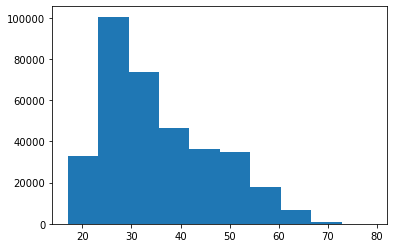

In [14]:
plt.hist(trips_station_weather['age'])

In [15]:
# Define bins and labels for age groups
bins = [-1, 16, 25, 35, 40, 55, 100]
labels = ['Missing', '16-25', '26-30', '31-35', '36-55', '56+']

# Bin the age column based on bike usage
trips_station_weather['age'] = trips_station_weather['age'].fillna(0)
trips_station_weather['age_group'] = pd.cut(trips_station_weather['age'], bins=bins, labels=labels)

#### 4d Date and Time Feature Extraction and Encoding

- The code block mentioned here contains a set of functions that aim to extract various relevant date and time features from a datetime column and encode them in a cyclical manner. This approach is particularly useful in time-series analysis, where the temporal patterns are cyclical in nature.

- The features extracted by these functions include day of the week, month, day, hour, week of the year, and additional features such as whether a date falls on a weekend and the time of day. These features are often used as input variables in predictive models that aim to forecast trends or patterns in time-series data.

- To encode these features in a cyclical manner, the functions use sine and cosine functions. Sine and cosine functions are periodic, which means they can represent cyclical patterns in time. For instance, the sine function repeats itself every 2π radians or 360 degrees, and the cosine function repeats itself every π/2 radians or 90 degrees.

- By using sine and cosine functions to encode the extracted features, the functions represent cyclical patterns in a compact and continuous way. This approach is particularly useful when working with cyclical features such as hours of the day or months of the year, where traditional encoding techniques such as one-hot encoding can result in high-dimensional and sparse feature representations.

- Overall, these functions are useful in extracting and encoding relevant time features from a datetime column, allowing for the efficient analysis and modeling of cyclical time-series data.

In [16]:
def extract_date_info(dt):
    if dt.weekday() in [5, 6]:
        weekend = 1  
    else:
        weekend = 0
        
    hour = dt.hour
    if hour < 6:
        time_of_day = 'early morning'
    elif hour < 10:
        time_of_day = 'rush hour'
    elif hour < 16:
        time_of_day = 'afternoon'
    elif hour < 18:
        time_of_day = 'evening'
    else:
        time_of_day = 'night'

    month = dt.month
    if month in [12, 1, 2]:
        season = 'winter'
    elif month in [3, 4, 5]:
        season = 'spring'
    elif month in [6, 7, 8]:
        season = 'summer'
    else:
        season = 'fall'
    return [weekend, time_of_day, season]

def encode_cyclical(row):
    hour_sin = np.sin(2 * np.pi * row['start_hour'] / 24)
    hour_cos = np.cos(2 * np.pi * row['start_hour'] / 24)
    dow_sin = np.sin(2 * np.pi * row['start_day_of_week'] / 7)
    dow_cos = np.cos(2 * np.pi * row['start_day_of_week'] / 7)
    month_sin = np.sin(2 * np.pi * row['start_month'] / 12)
    month_cos = np.cos(2 * np.pi * row['start_month'] / 12)
    day_sin = np.sin(2 * np.pi * row['start_day'] / 31)
    day_cos = np.cos(2 * np.pi * row['start_day'] / 31)
    week_sin = np.sin(2 * np.pi * row['start_week_of_year'] / 52)
    week_cos = np.cos(2 * np.pi * row['start_week_of_year'] / 52)
    return pd.Series([hour_sin, hour_cos, dow_sin, dow_cos, month_sin, month_cos, week_sin, week_cos, day_sin, day_cos])

# Extract day of week, month, day, hour, and week of year from start_date
trips_station_weather['start_day_of_week'] = trips_station_weather['start_date'].dt.dayofweek
trips_station_weather['start_month'] = trips_station_weather['start_date'].dt.month
trips_station_weather['start_day'] = trips_station_weather['start_date'].dt.day
trips_station_weather['start_hour'] = trips_station_weather['start_date'].dt.hour
trips_station_weather['start_week_of_year'] = trips_station_weather['start_date'].dt.isocalendar().week

encoded_trip = trips_station_weather.apply(encode_cyclical, axis=1)
encoded_trip.columns = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'day_sin', 'day_cos']

trips_station_weather[['weekend', 'time_of_day','season']] = trips_station_weather['start_date'].apply(extract_date_info).apply(pd.Series)
trips_station_weather = pd.concat([trips_station_weather, encoded_trip], axis=1)

array([<AxesSubplot:title={'center':'start_hour'}>], dtype=object)

array([<AxesSubplot:title={'center':'start_week_of_year'}>], dtype=object)

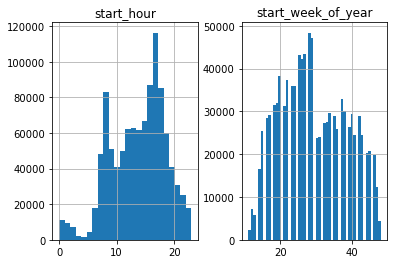

In [17]:
#Visualizing the distribution of start hours and start weeks of the year to determine the bins for hours and month.
fig, axes = plt.subplots(1, 2)
trips_station_weather.hist('start_hour', bins = 24, ax=axes[0])
trips_station_weather.hist('start_week_of_year',ax=axes[1], bins = 53)

In [18]:
#Drop unnecessary columns
drop_cols = ['start_date', 'strt_statn', 'age', 'birth_date', 'zip_code']
trips_station_weather.drop(columns = drop_cols, inplace = True)

#Convert data to correct datatype
for i in ['end_statn']:
    trips_station_weather[i] = trips_station_weather[i].astype(float)
trips_station_weather['start_week_of_year'] = trips_station_weather['start_week_of_year'].astype(int)

## 5 Train Test Validation Split

In [180]:
X = trips_station_weather.drop("end_statn", axis = 1)
y = trips_station_weather['end_statn']

#Split the data into X and y
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=40, stratify = y)

#Further split the validation set into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem,test_size=0.5, random_state=40, stratify = y_rem)

## 6 Feature Scaling & Feature Encoding

- Apply Standard Scaler to all numeric columns that do not contain outliers.
- Use Robust Scaler to scale the HPCP column.
- Perform Ordinal Encoding on the columns with 2 unique values.
- For categorical columns with more than two unique values, use One-Hot Encoding to encode the data.

In [186]:
scaler = StandardScaler()

#numeric_cols = X.select_dtypes(include=['float']).columns.tolist()
numeric_cols = ['strt_statn_lat','strt_statn_lng','mean_euclidean_dist','home_lat','home_lng','hour_sin','hour_cos','dow_sin','dow_cos', 'month_sin','month_cos','week_sin','week_cos','day_sin','day_cos']

# Fit and transform the training set
X_train[numeric_cols]  = scaler.fit_transform(X_train[numeric_cols])

# Transform the validation set using the scaler fitted on the training set
X_valid[numeric_cols] = scaler.transform(X_valid[numeric_cols])

# Transform the test set using the scaler fitted on the training set
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Instantiate the RobustScaler object
robust_scaler = RobustScaler()

# Fit and transform the training set
X_train[['HPCP']] = robust_scaler.fit_transform(X_train[['HPCP']])

# Transform the validation set using the scaler fitted on the training set
X_valid[['HPCP']] = robust_scaler.transform(X_valid[['HPCP']])

# Transform the test set using the scaler fitted on the training set
X_test[['HPCP']] = robust_scaler.transform(X_test[['HPCP']])

ordinal_cols = ['subsc_type']
ordinal_encoder = OrdinalEncoder()

# create an Ordinal encoder for binary features
encoded_binary_train = ordinal_encoder.fit_transform(X_train[ordinal_cols])
encoded_binary_valid = ordinal_encoder.transform(X_valid[ordinal_cols])
encoded_binary_test = ordinal_encoder.transform(X_test[ordinal_cols])

# convert encoded features to new DataFrames
encoded_binary_train = pd.DataFrame(encoded_binary_train, columns=ordinal_encoder.get_feature_names_out(ordinal_cols))
encoded_binary_valid = pd.DataFrame(encoded_binary_valid, columns=ordinal_encoder.get_feature_names_out(ordinal_cols))
encoded_binary_test = pd.DataFrame(encoded_binary_test, columns=ordinal_encoder.get_feature_names_out(ordinal_cols))

string_cols = (X.select_dtypes(include=['object','category']).columns.tolist())[1:]

# create an one-hot encoder for categorical features
onehot_encoder = OneHotEncoder(sparse_output=False)
encoded_categories_train = onehot_encoder.fit_transform(X_train[string_cols])
encoded_categories_valid = onehot_encoder.transform(X_valid[string_cols])
encoded_categories_test = onehot_encoder.transform(X_test[string_cols])

# convert encoded features to new DataFrames
encoded_categories_train = pd.DataFrame(encoded_categories_train, columns=onehot_encoder.get_feature_names_out(string_cols))
encoded_categories_valid = pd.DataFrame(encoded_categories_valid, columns=onehot_encoder.get_feature_names_out(string_cols))
encoded_categories_test = pd.DataFrame(encoded_categories_test, columns=onehot_encoder.get_feature_names_out(string_cols))


X_train_encoded = pd.concat([X_train.reset_index(drop = True), encoded_binary_train,encoded_categories_train], axis=1)
X_valid_encoded = pd.concat([X_valid.reset_index(drop = True), encoded_binary_valid,encoded_categories_valid], axis=1)
X_test_encoded = pd.concat([X_test.reset_index(drop = True), encoded_binary_test,encoded_categories_test], axis=1)

In [187]:
string_cols.append('subsc_type')
string_cols.extend(['start_day_of_week','start_month','start_day','start_hour','start_week_of_year'])
X_train_encoded.drop(columns = string_cols, inplace= True)
X_valid_encoded.drop(columns = string_cols, inplace= True)
X_test_encoded.drop(columns = string_cols, inplace= True)

## 7. Oversampling to Balance Class Imbalance

- I noticed a significant class imbalance in our target class, with some targets having over 40,000 rows and others with as few as 57 rows. To address this issue, I implement oversampling to create a more balanced dataset and improve the model's ability to generalize and make accurate predictions for both majority and minority classes. I choose oversampling over undersampling because oversampling does not discard any data. Also oversampling can also help preserve important patterns and relationships in the data, which may be lost if instances are removed through undersampling.

In [205]:
#Identify class_imblanace
y.value_counts()

22.0     42426
36.0     31792
42.0     26805
33.0     22923
53.0     22590
         ...  
105.0      234
134.0      173
144.0      129
143.0       70
142.0       57
Name: end_statn, Length: 125, dtype: int64

In [ ]:
sm = SMOTE(random_state=42)
X_train_encoded_balanced, y_balanced = sm.fit_resample(X_train_encoded, y_train)

## 8. Model Building

Due to CPU constraints, I was unable to run grid search or Bayesian optimization on all models. Therefore, I will rely on intuitive hyperparameter settings. 

#### 8a Random Forest

- Given the significant number of distance variables in this multi-class classification problem, I have decided to use the Random Forest algorithm. Random Forest is a suitable choice for this problem because it is capable of handling high-dimensional data and can identify relevant variables while reducing the impact of irrelevant variables. Furthermore, as a tree-based model, it is effective at capturing complex relationships between variables and decision boundaries. Additionally, Random Forest can handle imbalanced datasets and is less prone to overfitting compared to other models such as decision trees. By using Random Forest, I can expect a robust and accurate model that is able to generalize well to new data.

In [ ]:
#Grid Search
'''
param_grid = {'n_estimators': (10, 1000),
            'max_depth': (2, 50),
            'min_samples_split': (2, 20),
            'max_features': (0.1, 1.0)}

rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid=param_grid, cv= 2)
grid_search.fit(X_train_val, y_train_val)
# Get the best hyperparameters
best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']

'''

In [208]:
# Combine the training and validation sets
X_train_val = np.concatenate((X_train_encoded, X_valid_encoded))
y_train_val = np.concatenate((y_train, y_valid))

#Grid Search
rf = RandomForestClassifier(n_estimators=100, random_state=42,max_depth = 15, min_samples_split  = 3)
rf.fit(X_train_val, y_train_val)

RandomForestClassifier(max_depth=15, min_samples_split=3, random_state=42)

In [209]:
def print_metrics(y_true, y_pred, prefix):
    print(prefix + " Accuracy Score:", accuracy_score(y_true, y_pred))
    print(prefix + " Precision Score:", precision_score(y_true, y_pred, average='weighted'))
    print(prefix + " Recall Score:", recall_score(y_true, y_pred, average='weighted'))
    print(prefix + " F1 Score:", f1_score(y_true, y_pred, average='weighted'))

# Make predictions on the validation and test data
y_train_val_pred = rf.predict(X_train_val)
y_test_pred = rf.predict(X_test_encoded)

# Print the metrics for the validation and test data
print_metrics(y_train_val, y_train_val_pred, "Train_Valid")
print_metrics(y_test, y_test_pred, "Test")

C:\Users\gratz\anaconda3\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Train_Valid Accuracy Score: 0.36385957658131934
Train_Valid Precision Score: 0.4401443869062015
Train_Valid Recall Score: 0.36385957658131934
Train_Valid F1 Score: 0.3624472607933242
Test Accuracy Score: 0.2735486222341578
Test Precision Score: 0.3245982307552732
Test Recall Score: 0.2735486222341578
Test F1 Score: 0.26621291666039243


C:\Users\gratz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 8b Gradient Boost
- When it comes to predicting bike ending trip context, Gradient Boost is a strong model choice due to its ability to handle a large number of distance features and multi-class classification. The model's ability to capture complex non-linear relationships between the features and target variable can improve predictive accuracy by revealing the underlying structure of the data. This is especially important in predicting bike ending trip context, where there may be complex relationships between variables such as distance, time of day, and weather conditions(HPCP).


- Furthermore, Gradient Boost's ability to handle high-dimensional data makes it well-suited for problems with many potential predictors, such as the rider's age or gender. The model's ability to handle a large number of predictors can lead to more accurate predictions and help identify the key factors that contribute to bike ending trip context.


In [ ]:
gb = GradientBoostingClassifier(n_estimators=15, learning_rate=0.3, max_depth=2, random_state=42)

# fit the classifier to the training data
gb.fit(X_train_val, y_train_val)

In [ ]:
def print_metrics(y_true, y_pred, prefix):
    print(prefix + " Accuracy Score:", accuracy_score(y_true, y_pred))
    print(prefix + " Precision Score:", precision_score(y_true, y_pred, average='weighted'))
    print(prefix + " Recall Score:", recall_score(y_true, y_pred, average='weighted'))
    print(prefix + " F1 Score:", f1_score(y_true, y_pred, average='weighted'))

# Make predictions on the validation and test data
y_train_val_pred = gb.predict(X_train_val)
y_test_pred = gb.predict(X_test_encoded)

# Print the metrics for the validation and test data
print_metrics(y_train_val, y_train_val_pred, "Train_Valid")
print_metrics(y_test, y_test_pred, "Test")

#### 8c SVM
- When it comes to predicting bike end station context, SVM is a highly suitable model due to its ability to effectively handle datasets with many distance variables. In this context, distance variables are likely to play a key role in determining the end station of a bike ride. Additionally, SVM is highly effective at handling non-linearly separable data, which is useful when there are complex relationships between the predictors and the target variable.

In [ ]:
svm = SVC(kernel='linear', C=1, gamma='auto')
svm.fit(X_train_val, y_train_val)

In [ ]:
def print_metrics(y_true, y_pred, prefix):
    print(prefix + " Accuracy Score:", accuracy_score(y_true, y_pred))
    print(prefix + " Precision Score:", precision_score(y_true, y_pred, average='weighted'))
    print(prefix + " Recall Score:", recall_score(y_true, y_pred, average='weighted'))
    print(prefix + " F1 Score:", f1_score(y_true, y_pred, average='weighted'))

# Make predictions on the validation and test data
y_train_val_pred = gb.predict(X_train_val)
y_test_pred = gb.predict(X_test_encoded)

# Print the metrics for the validation and test data
print_metrics(y_train_val, y_train_val_pred, "Train_Valid")
print_metrics(y_test, y_test_pred, "Test")

## 9. Conclusion

Overall, the result of this project is moderately successful. We achieved an accuracy rate of approximately 30% for a multi-class classification problem with 125 labels, which is a good start but leaves room for improvement. One potential area for improvement is to explore the use of more advanced machine learning models, particularly deep learning models, which are known for their ability to capture complex patterns in data. This may help to further improve the accuracy of the model and potentially uncover new insights into the factors that influence bike usage.

Another possible improvement is to gather more detailed information about the users themselves, such as their gender and age. By collecting this information, we can better understand how different demographics use bikes and potentially identify new factors that influence usage. Additionally, we could consider adding more features to the model, such as additional weather conditions or even information about the terrain of the route. This could help to provide a more comprehensive understanding of the factors that influence bike usage and lead to more accurate predictions.

In conclusion, while the current model has achieved a moderate level of success, there are several areas where we can improve its performance. By exploring advanced machine learning models, gathering more detailed user information, and incorporating additional features into the model, we can continue to refine our understanding of bike usage and make more accurate predictions.